#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [1]:
#!pip install pandas
!pip install tensorflow

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [2]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

# Importamos las librerias necesarias para los experimentos

In [3]:
import pandas
import numpy as np
import os
import tensorflow as tf
import cv2
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential



Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [5]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Chequeo de cantidad de imágenes cargadas en cada directorio.

In [6]:
cataract_images = glob.glob(train_dir+"/Cataract/*.jpg")
diabetic_retinopathy_images = glob.glob(train_dir+"/Diabetic_Retinopathy/*.jpg")
glaucoma_images = glob.glob(train_dir+"/Glaucoma/*.jpg")
healthy_images = glob.glob(train_dir+"/Healthy/*.jpg")
macular_scar_images = glob.glob(train_dir+"/Macular_Scar/*.jpg")
myopia_images = glob.glob(train_dir+"/Myopia/*.jpg")

print(len(cataract_images))
print(len(diabetic_retinopathy_images))
print(len(glaucoma_images))
print(len(healthy_images))
print(len(macular_scar_images))
print(len(myopia_images))

732
1056
944
717
933
1050


## Generamos un grafico de torta para ver la cantidad de imagenes

De esta forma se puede observar la distribución de clases y el balanceo de clases.

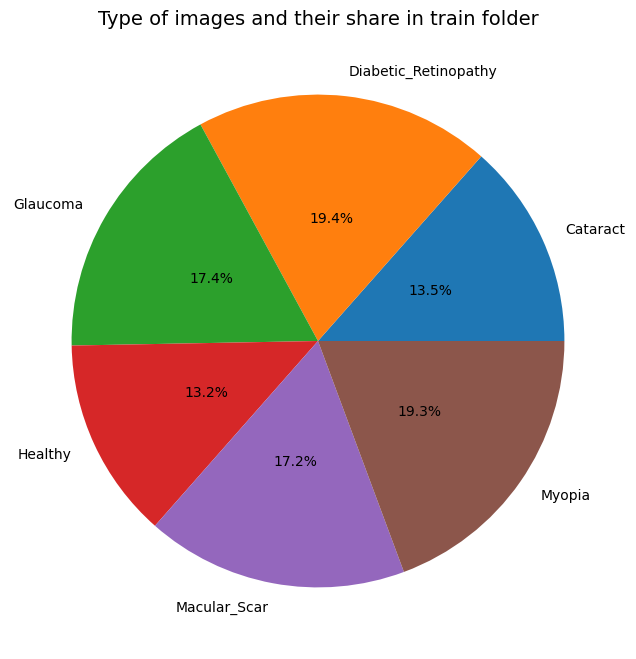

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(x=np.array([len(cataract_images), len(diabetic_retinopathy_images),
                    len(glaucoma_images),len(healthy_images), len(macular_scar_images),
                    len(myopia_images)
                    ]), autopct="%.1f%%", labels=["Cataract", "Diabetic_Retinopathy", "Glaucoma", "Healthy",
                                                  "Macular_Scar", "Myopia"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


In [9]:
input_shape = (224, 224, 3)

## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [10]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(12,12))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(12,12))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  ax1.set_xlabel('Predicción')
  ax2.set_xlabel('Predicción')
  ax1.set_ylabel('Real')
  ax2.set_ylabel('Real')
  plt.show()

La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [13]:
from sklearn.metrics import classification_report
def calcular_metricas_por_clase(y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [14]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model1 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model1.layers:
    layer.trainable = False

model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(6, activation='softmax'))


# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 86s 794ms/step - loss: 1.1722 - accuracy: 0.5390 - precision: 0.7307 - recall: 0.3310 - auc: 0.8555 - val_loss: 1.0053 - val_accuracy: 0.6062 - val_precision: 0.7114 - val_recall: 0.4916 - val_auc: 0.8986
Epoch 2/20
100/100 [==============================] - 78s 780ms/step - loss: 0.8776 - accuracy: 0.6480 - precision: 0.7830 - recall: 0.4980 - auc: 0.9228 - val_loss: 0.8602 - val_accuracy: 0.6770 - val_precision: 0.8030 - val_recall: 0.5245 - val_auc: 0.9262
Epoch 3/20
100/100 [==============================] - 78s 781ms/step - loss: 0.8431 - accuracy: 0.6655 - precision: 0.7598 - recall: 0.5425 - auc: 0.9279 - val_loss: 0.8262 - val_accuracy: 0.6551 - val_precision: 0.7709 - val_recall: 0.5650 - val_auc: 0.9302
Epoch 4/20
100/100 [==============================] - 79s 789ms/step - loss: 0.7667 - accuracy: 0.6943 - precision: 0.7850 - recall: 0.5919 - auc: 0.9408 - val_loss: 0.7291 - val_accuracy: 0.7259 - val_precision: 0.8262 - v

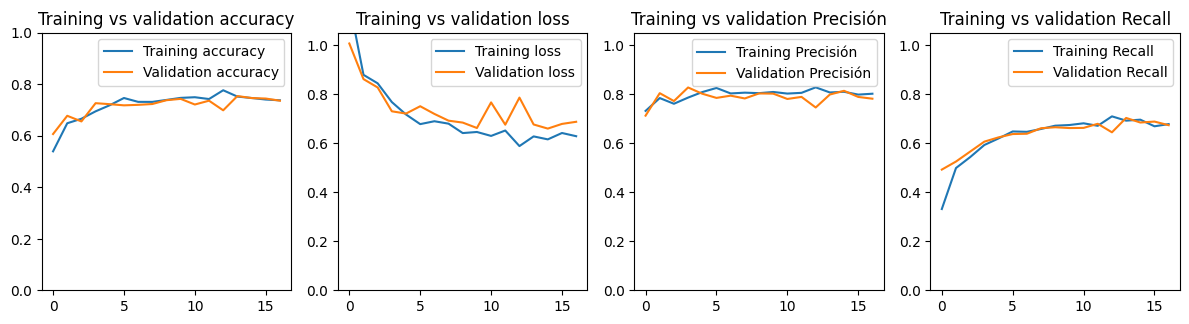

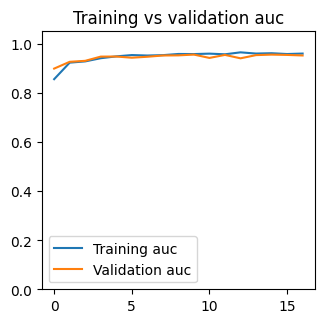

In [ ]:
graph(history1)

39/39 [==============================] - 15s 396ms/step


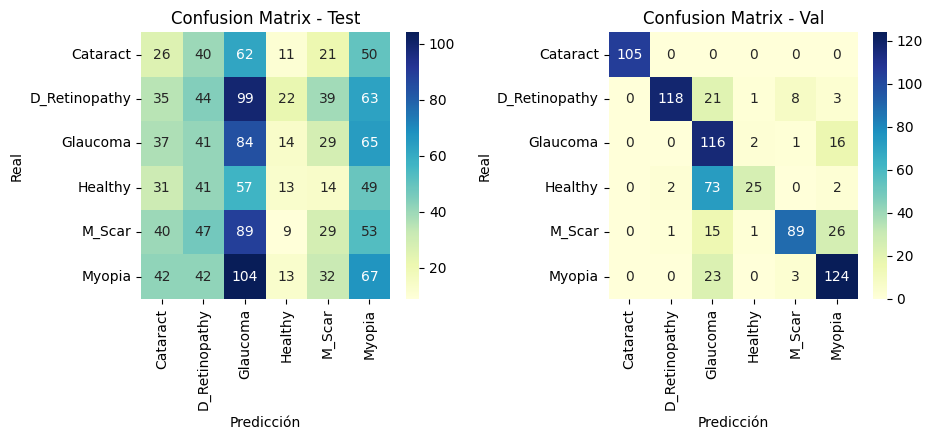

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.17      0.15      0.16       302
           2       0.17      0.31      0.22       270
           3       0.16      0.06      0.09       205
           4       0.18      0.11      0.13       267
           5       0.19      0.22      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.16      0.16      1554
weighted avg       0.17      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.98      0.78      0.87       151
           2       0.47      0.86      0.61       135
           3       0.86      0.25      0.38       102
           4       0.88      0.67      0.76       132
           5       0.73      0.83      0.77       150

    accuracy                           0.74       775
   macro avg       0.82

## Modelo 4

In [ ]:
base_model4 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 7333574 (27.98 MB)
Trainable params: 296070

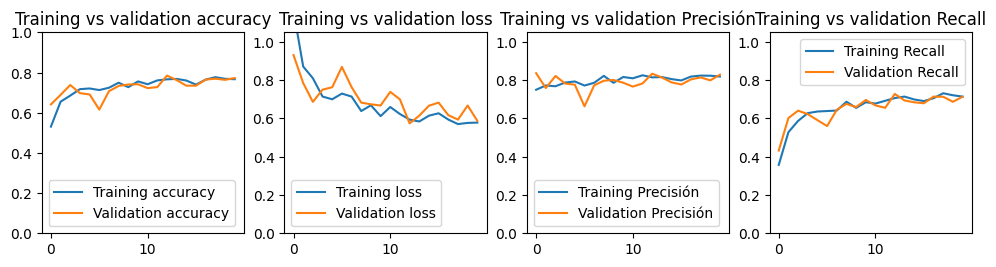

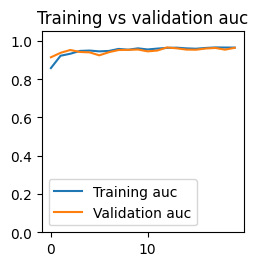

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 11s 298ms/step


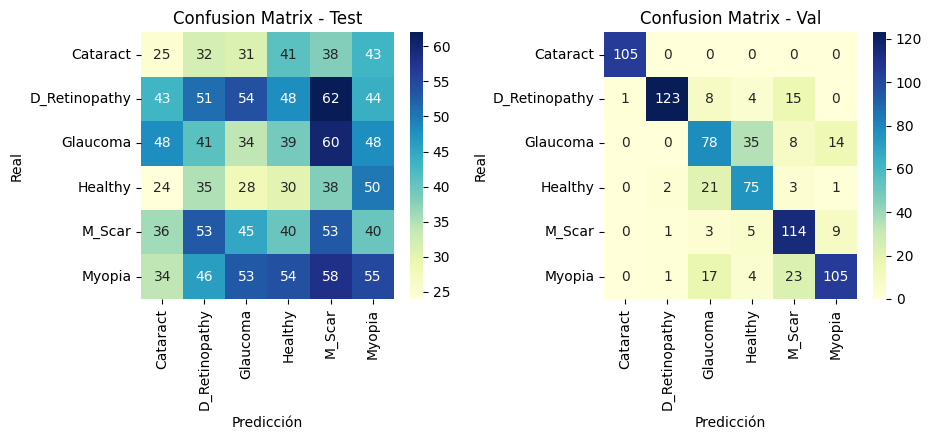

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.20      0.17      0.18       302
           2       0.14      0.13      0.13       270
           3       0.12      0.15      0.13       205
           4       0.17      0.20      0.18       267
           5       0.20      0.18      0.19       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.97      0.81      0.88       151
           2       0.61      0.58      0.60       135
           3       0.61      0.74      0.67       102
           4       0.70      0.86      0.77       132
           5       0.81      0.70      0.75       150

    accuracy                           0.77       775
   macro avg       0.78

## Modelo 5

In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model5 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model5.layers:
    layer.trainable = False

model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))

# Compilar el modelo
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 91s 816ms/step - loss: 1.2559 - accuracy: 0.4940 - precision: 0.7365 - recall: 0.2877 - auc: 0.8324 - val_loss: 0.9046 - val_accuracy: 0.5985 - val_precision: 0.8754 - val_recall: 0.3797 - val_auc: 0.9176
Epoch 2/20
100/100 [==============================] - 82s 823ms/step - loss: 0.9781 - accuracy: 0.5985 - precision: 0.7266 - recall: 0.4505 - auc: 0.9013 - val_loss: 0.9824 - val_accuracy: 0.5997 - val_precision: 0.8099 - val_recall: 0.4440 - val_auc: 0.9008
Epoch 3/20
100/100 [==============================] - 96s 963ms/step - loss: 0.8883 - accuracy: 0.6396 - precision: 0.7519 - recall: 0.5020 - auc: 0.9194 - val_loss: 0.8140 - val_accuracy: 0.6828 - val_precision: 0.8432 - val_recall: 0.5154 - val_auc: 0.9335
Epoch 4/20
100/100 [==============================] - 82s 818ms/step - loss: 0.8492 - accuracy: 0.6575 - precision: 0.7796 - recall: 0.5200 - auc: 0.9263 - val_loss: 0.7282 - val_accuracy: 0.7304 - val_precision: 0.8415 - v

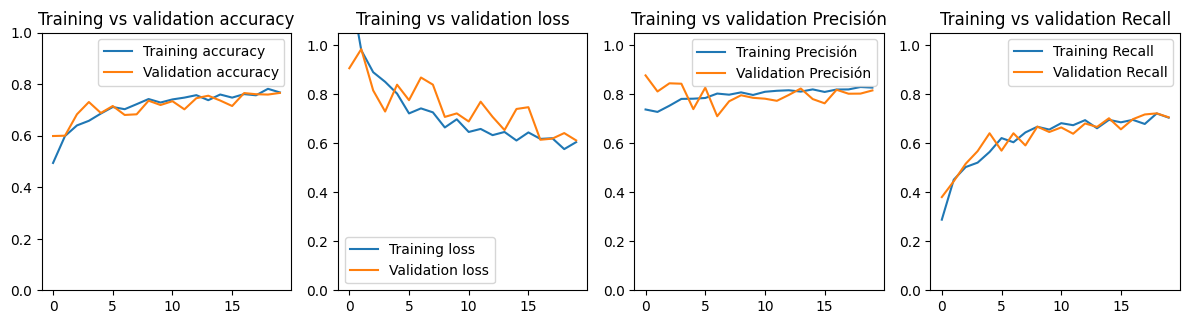

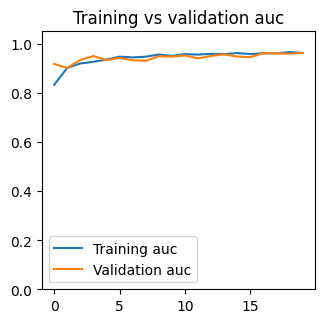

In [ ]:
graph(history5)

39/39 [==============================] - 13s 335ms/step


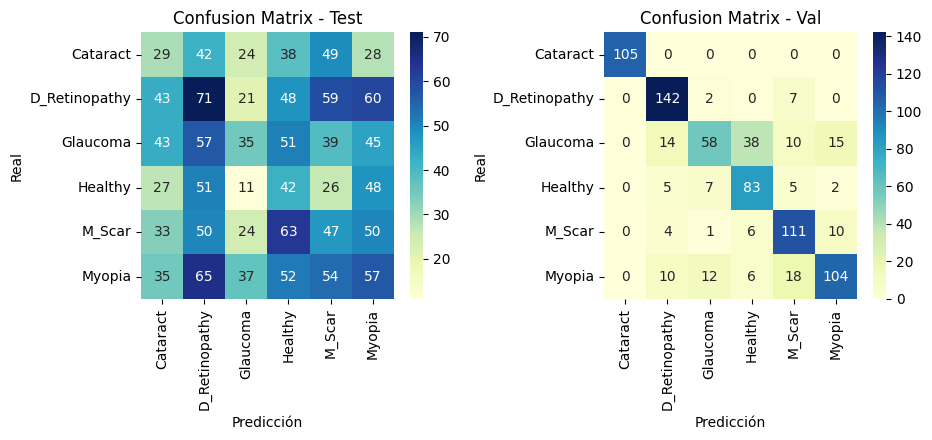

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.21      0.24      0.22       302
           2       0.23      0.13      0.17       270
           3       0.14      0.20      0.17       205
           4       0.17      0.18      0.17       267
           5       0.20      0.19      0.19       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.19      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.81      0.94      0.87       151
           2       0.72      0.43      0.54       135
           3       0.62      0.81      0.71       102
           4       0.74      0.84      0.78       132
           5       0.79      0.69      0.74       150

    accuracy                           0.78       775
   macro avg       0.78

## Modelo 15

In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model15 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model15.layers:
    layer.trainable = False

model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 131s 766ms/step - loss: 1.0172 - accuracy: 0.5969 - precision: 0.7921 - recall: 0.4024 - auc: 0.8962 - val_loss: 0.7609 - val_accuracy: 0.7143 - val_precision: 0.8236 - val_recall: 0.5830 - val_auc: 0.9429
Epoch 2/25
150/150 [==============================] - 104s 691ms/step - loss: 0.7717 - accuracy: 0.6922 - precision: 0.7944 - recall: 0.5926 - auc: 0.9399 - val_loss: 0.7564 - val_accuracy: 0.7194 - val_precision: 0.7945 - val_recall: 0.6493 - val_auc: 0.9426
Epoch 3/25
150/150 [==============================] - 101s 676ms/step - loss: 0.7055 - accuracy: 0.7229 - precision: 0.8000 - recall: 0.6377 - auc: 0.9495 - val_loss: 0.8291 - val_accuracy: 0.6744 - val_precision: 0.7498 - val_recall: 0.6075 - val_auc: 0.9310
Epoch 4/25
150/150 [==============================] - 103s 686ms/step - loss: 0.6878 - accuracy: 0.7330 - precision: 0.8011 - recall: 0.6568 - auc: 0.9519 - val_loss: 0.6938 - val_accuracy: 0.7329 - val_precision: 0.7835

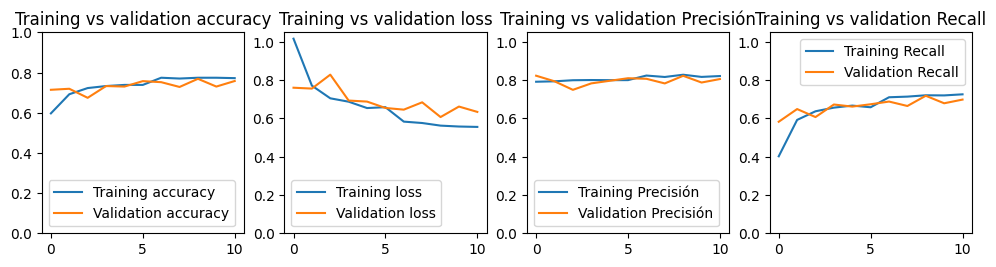

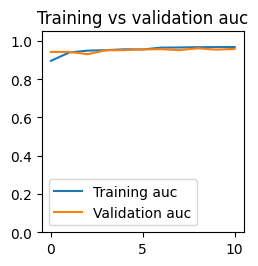

In [ ]:
graph(history15)

39/39 [==============================] - 16s 413ms/step


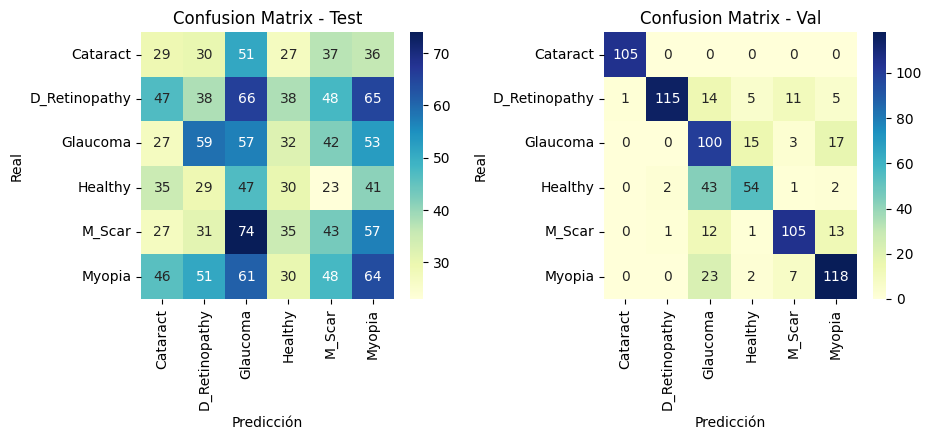

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.16      0.13      0.14       302
           2       0.16      0.21      0.18       270
           3       0.16      0.15      0.15       205
           4       0.18      0.16      0.17       267
           5       0.20      0.21      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.97      0.76      0.86       151
           2       0.52      0.74      0.61       135
           3       0.70      0.53      0.60       102
           4       0.83      0.80      0.81       132
           5       0.76      0.79      0.77       150

    accuracy                           0.77       775
   macro avg       0.80

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 2056)              2107400   
                                                                 
 dropout (Dropout)           (None, 2056)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                      

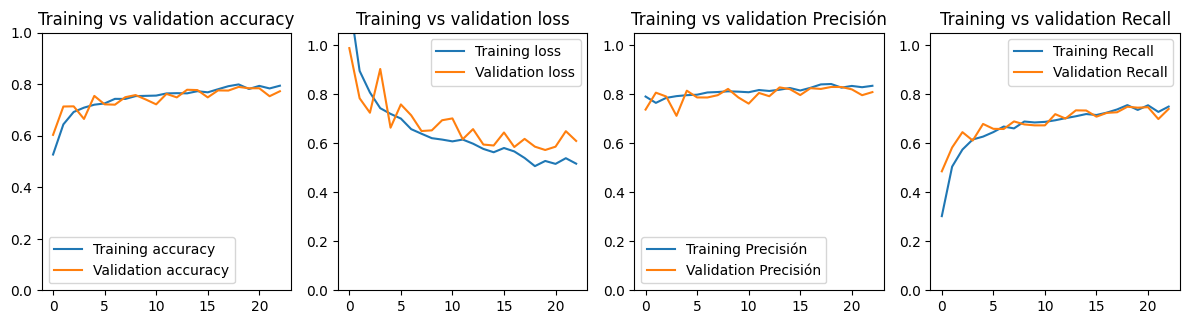

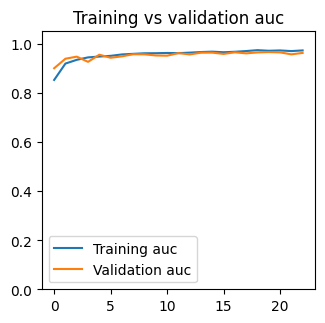

In [ ]:
graph(history16)

39/39 [==============================] - 14s 361ms/step


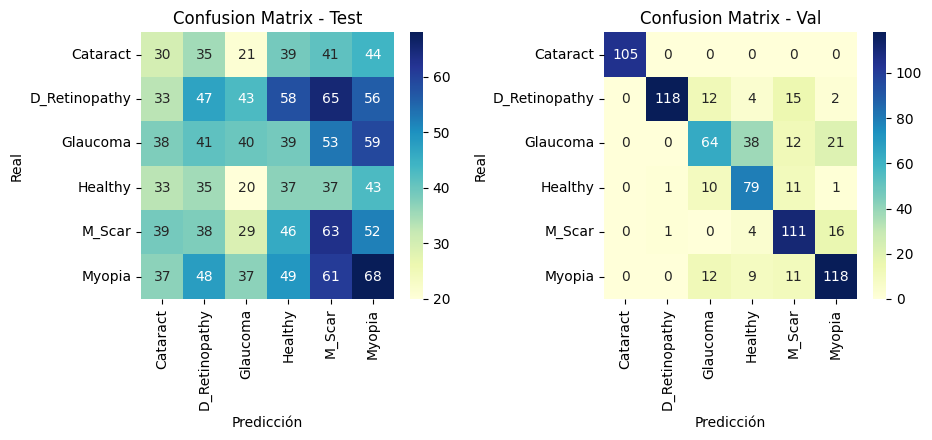

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.19      0.16      0.17       302
           2       0.21      0.15      0.17       270
           3       0.14      0.18      0.16       205
           4       0.20      0.24      0.21       267
           5       0.21      0.23      0.22       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.19      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.98      0.78      0.87       151
           2       0.65      0.47      0.55       135
           3       0.59      0.77      0.67       102
           4       0.69      0.84      0.76       132
           5       0.75      0.79      0.77       150

    accuracy                           0.77       775
   macro avg       0.78

## Modelo 6

In [15]:
base_model6 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5112)              5239800   
                                                                 
 dense_1 (Dense)             (None, 2056)              10512328  
                                                                 
 dense_2 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_3 (Dense)             (None, 512)               52

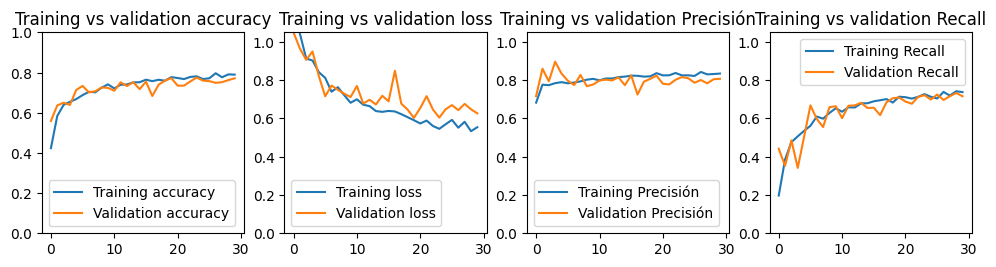

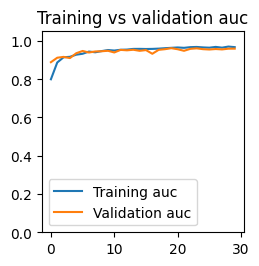

In [16]:
graph(history6)

In [17]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 11s 289ms/step


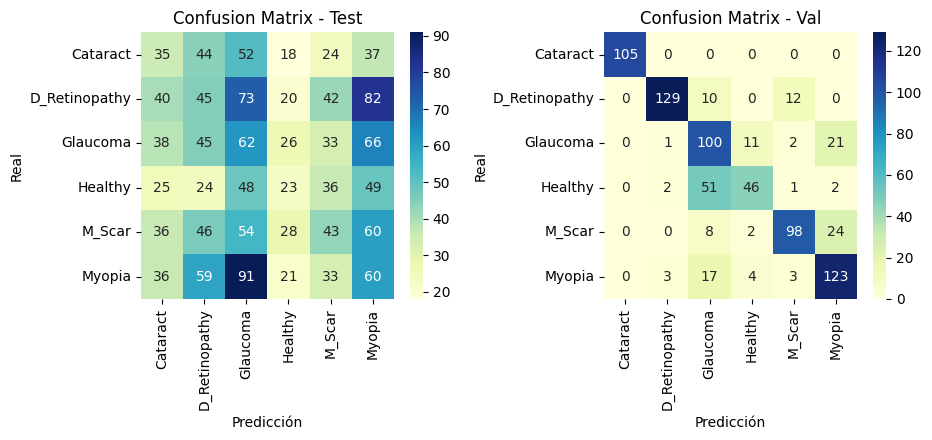

In [18]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [20]:
reporte = calcular_metricas_por_clase(y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       210
           1       0.17      0.15      0.16       302
           2       0.16      0.23      0.19       270
           3       0.17      0.11      0.13       205
           4       0.20      0.16      0.18       267
           5       0.17      0.20      0.18       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.96      0.85      0.90       151
           2       0.54      0.74      0.62       135
           3       0.73      0.45      0.56       102
           4       0.84      0.74      0.79       132
           5       0.72      0.82      0.77       150

    accuracy                           0.78       775
   macro avg       0.80

## Modelo 20

In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model20 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model20.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model20.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model20 = Model(inputs=base_model20.input, outputs=predictions)

# Compilar el modelo
model20.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model20.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model20.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 97s 878ms/step - loss: 1.3766 - accuracy: 0.4460 - precision: 0.8076 - recall: 0.1385 - auc: 0.7968 - val_loss: 1.0859 - val_accuracy: 0.5798 - val_precision: 0.8665 - val_recall: 0.2716 - val_auc: 0.8911
Epoch 2/20
100/100 [==============================] - 94s 949ms/step - loss: 1.0229 - accuracy: 0.6185 - precision: 0.8275 - recall: 0.3455 - auc: 0.9019 - val_loss: 0.9035 - val_accuracy: 0.6828 - val_precision: 0.8586 - val_recall: 0.4376 - val_auc: 0.9303
Epoch 3/20
100/100 [==============================] - 79s 789ms/step - loss: 0.9067 - accuracy: 0.6541 - precision: 0.8329 - recall: 0.4503 - auc: 0.9227 - val_loss: 0.8623 - val_accuracy: 0.6834 - val_precision: 0.8291 - val_recall: 0.4839 - val_auc: 0.9310
Epoch 4/20
100/100 [==============================] - 79s 789ms/step - loss: 0.8179 - accuracy: 0.7015 - precision: 0.8253 - recall: 0.5150 - auc: 0.9380 - val_loss: 0.8280 - val_accuracy: 0.6873 - val_precision: 0.8231 - v

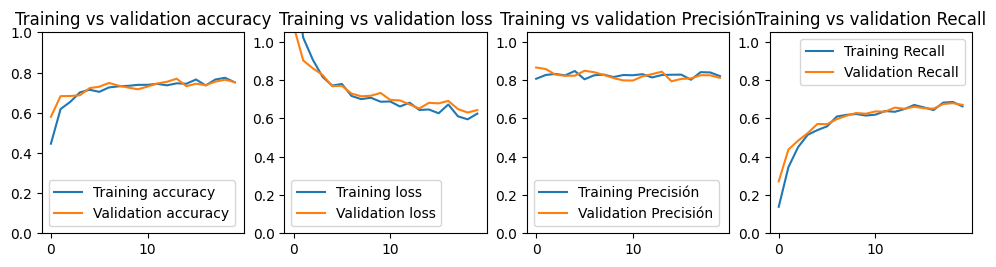

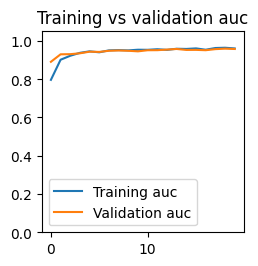

In [ ]:
graph(history_dense)

39/39 [==============================] - 15s 395ms/step


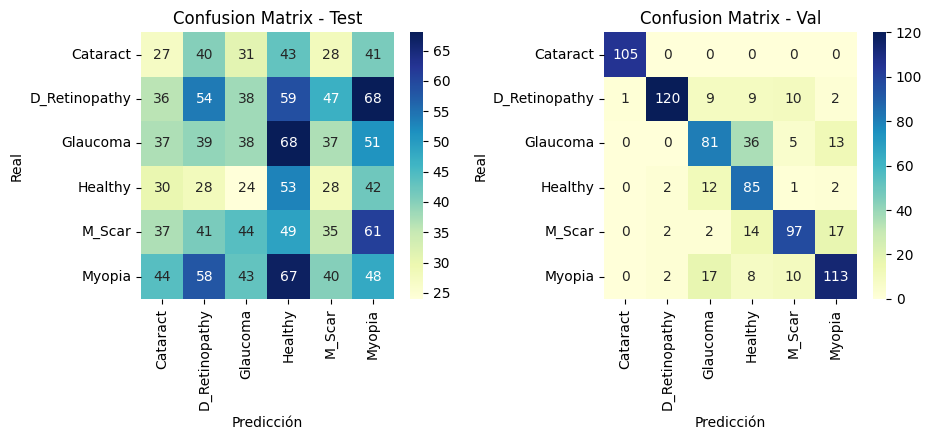

In [ ]:
y_pred_test = model20.predict(test_generator)
y_pred_val = model20.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.21      0.18      0.19       302
           2       0.17      0.14      0.16       270
           3       0.16      0.26      0.19       205
           4       0.16      0.13      0.15       267
           5       0.15      0.16      0.16       300

    accuracy                           0.16      1554
   macro avg       0.16      0.17      0.16      1554
weighted avg       0.17      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.95      0.79      0.87       151
           2       0.67      0.60      0.63       135
           3       0.56      0.83      0.67       102
           4       0.79      0.73      0.76       132
           5       0.77      0.75      0.76       150

    accuracy                           0.78       775
   macro avg       0.79

## Modelo 19

In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 121s 749ms/step - loss: 1.5368 - accuracy: 0.3429 - precision: 0.7564 - recall: 0.0892 - auc: 0.7222 - val_loss: 1.1123 - val_accuracy: 0.5592 - val_precision: 0.8198 - val_recall: 0.2606 - val_auc: 0.8755
Epoch 2/25
150/150 [==============================] - 125s 836ms/step - loss: 1.1839 - accuracy: 0.5084 - precision: 0.7403 - recall: 0.3068 - auc: 0.8502 - val_loss: 0.9177 - val_accuracy: 0.6422 - val_precision: 0.8446 - val_recall: 0.4093 - val_auc: 0.9193
Epoch 3/25
150/150 [==============================] - 103s 690ms/step - loss: 1.0585 - accuracy: 0.5665 - precision: 0.7649 - recall: 0.3773 - auc: 0.8832 - val_loss: 0.8760 - val_accuracy: 0.6557 - val_precision: 0.7916 - val_recall: 0.4839 - val_auc: 0.9260
Epoch 4/25
150/150 [==============================] - 104s 693ms/step - loss: 1.0132 - accuracy: 0.5912 - precision: 0.7560 - recall: 0.3977 - auc: 0.8940 - val_loss: 0.8326 - val_accuracy: 0.7046 - val_precision: 0.8498

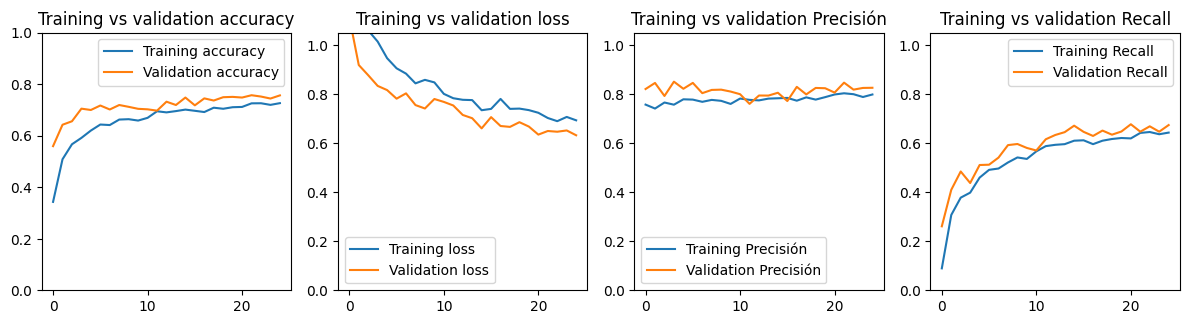

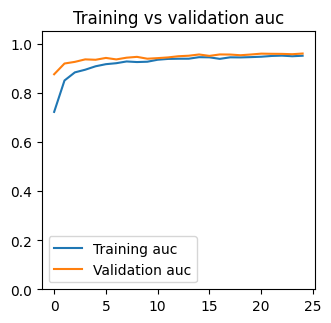

In [ ]:
graph(history19)

39/39 [==============================] - 12s 324ms/step


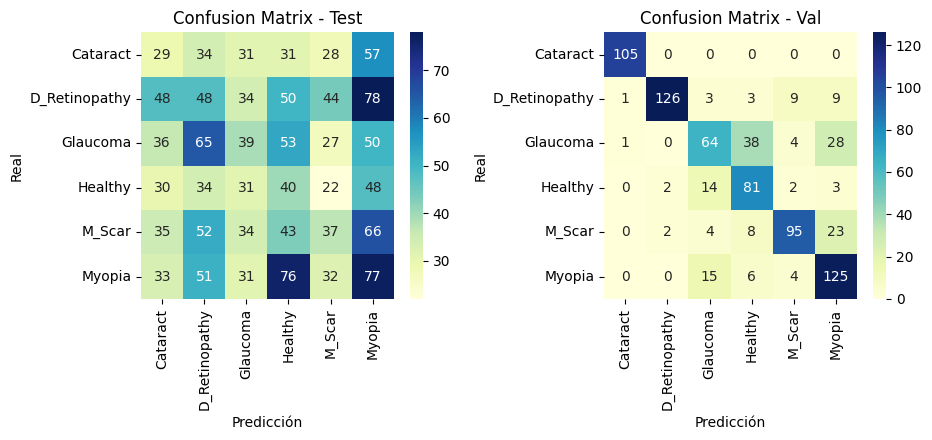

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.17      0.16      0.16       302
           2       0.20      0.14      0.17       270
           3       0.14      0.20      0.16       205
           4       0.19      0.14      0.16       267
           5       0.20      0.26      0.23       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.97      0.83      0.90       151
           2       0.64      0.47      0.54       135
           3       0.60      0.79      0.68       102
           4       0.83      0.72      0.77       132
           5       0.66      0.83      0.74       150

    accuracy                           0.77       775
   macro avg       0.78

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 142s 521ms/step - loss: 0.6554 - accuracy: 0.7244 - precision: 0.7678 - recall: 0.6854 - auc: 0.9565
Evaluar con Validación:
78/78 [==============================] - 26s 333ms/step - loss: 0.6864 - accuracy: 0.7355 - precision: 0.7804 - recall: 0.6725 - auc: 0.9520
Evaluar con Prueba:
39/39 [==============================] - 13s 349ms/step - loss: 0.6176 - accuracy: 0.7445 - precision: 0.7779 - recall: 0.6826 - auc: 0.9609


In [ ]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 124s 454ms/step - loss: 0.5247 - accuracy: 0.7944 - precision: 0.8477 - recall: 0.7336 - auc: 0.9722
Evaluar con Validación:
78/78 [==============================] - 21s 269ms/step - loss: 0.5881 - accuracy: 0.7728 - precision: 0.8288 - recall: 0.7136 - auc: 0.9642
Evaluar con Prueba:
39/39 [==============================] - 11s 290ms/step - loss: 0.5402 - accuracy: 0.7742 - precision: 0.8326 - recall: 0.7123 - auc: 0.9700


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 148s 544ms/step - loss: 0.5679 - accuracy: 0.7758 - precision: 0.8369 - recall: 0.7084 - auc: 0.9670
Evaluar con Validación:
78/78 [==============================] - 26s 330ms/step - loss: 0.6105 - accuracy: 0.7658 - precision: 0.8141 - recall: 0.7046 - auc: 0.9622
Evaluar con Prueba:
39/39 [==============================] - 13s 343ms/step - loss: 0.5425 - accuracy: 0.7781 - precision: 0.8190 - recall: 0.7123 - auc: 0.9701


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 146s 538ms/step - loss: 0.5167 - accuracy: 0.7984 - precision: 0.8476 - recall: 0.7443 - auc: 0.9730
Evaluar con Validación:
78/78 [==============================] - 26s 333ms/step - loss: 0.6345 - accuracy: 0.7580 - precision: 0.8062 - recall: 0.6988 - auc: 0.9585
Evaluar con Prueba:
39/39 [==============================] - 13s 340ms/step - loss: 0.5638 - accuracy: 0.7703 - precision: 0.8118 - recall: 0.7123 - auc: 0.9675


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 145s 532ms/step - loss: 0.4502 - accuracy: 0.8260 - precision: 0.8620 - recall: 0.7809 - auc: 0.9793
Evaluar con Validación:
78/78 [==============================] - 25s 317ms/step - loss: 0.6083 - accuracy: 0.7722 - precision: 0.8073 - recall: 0.7387 - auc: 0.9623
Evaluar con Prueba:
39/39 [==============================] - 13s 328ms/step - loss: 0.5566 - accuracy: 0.7677 - precision: 0.8069 - recall: 0.7226 - auc: 0.9684


In [21]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 122s 449ms/step - loss: 0.5433 - accuracy: 0.7859 - precision: 0.8225 - recall: 0.7364 - auc: 0.9694
Evaluar con Validación:
78/78 [==============================] - 22s 281ms/step - loss: 0.6269 - accuracy: 0.7716 - precision: 0.8077 - recall: 0.7162 - auc: 0.9598
Evaluar con Prueba:
39/39 [==============================] - 11s 283ms/step - loss: 0.5926 - accuracy: 0.7755 - precision: 0.8124 - recall: 0.7265 - auc: 0.9645


In [ ]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 141s 518ms/step - loss: 0.5759 - accuracy: 0.7774 - precision: 0.8525 - recall: 0.6935 - auc: 0.9679
Evaluar con Validación:
78/78 [==============================] - 25s 320ms/step - loss: 0.6314 - accuracy: 0.7561 - precision: 0.8249 - recall: 0.6731 - auc: 0.9599
Evaluar con Prueba:
39/39 [==============================] - 14s 354ms/step - loss: 0.5749 - accuracy: 0.7690 - precision: 0.8368 - recall: 0.6748 - auc: 0.9678


In [ ]:
evaluar_modelo(model20)

Evaluar con Entrenamiento:
272/272 [==============================] - 140s 514ms/step - loss: 0.5850 - accuracy: 0.7725 - precision: 0.8387 - recall: 0.6904 - auc: 0.9667
Evaluar con Validación:
78/78 [==============================] - 25s 320ms/step - loss: 0.6440 - accuracy: 0.7523 - precision: 0.8123 - recall: 0.6712 - auc: 0.9581
Evaluar con Prueba:
39/39 [==============================] - 14s 376ms/step - loss: 0.5829 - accuracy: 0.7755 - precision: 0.8178 - recall: 0.6890 - auc: 0.9661
